### PSY1401 - Group 5 - Project 4

Implementing the Working Memory Model of Botvinick & Watanabe (2007).

Implemented by Peter Jankowski, Philippe Noël, and Lizzy Schick

Task

1. Implement the working memory model of Botvinick & Watanabe (2007), and show that it can reproduce positional accuracy and transposition gradient effects.

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormap

%matplotlib inline

We will first implement the working memory model, simplifying it a little so to make for a more informative and simpler modeling.

## Task 1.1 Implementing the working memory model

We first define some of the properties and parameters of the model.

In [0]:
n_item = 6 # number of items
rank = 9 # Gershman said this is for granularity
n_internal = n_item * rank # number of hidden layer nodes
n_output = 720 # 720 possible target lists (6!)

# set parameters !!!!!
delta = 0        # degree of dissimilarity between item representations [0,1]
alpha = 0.001    # learning rate, fixed in paper
duration = 2500  # fixed in paper
v = 0            # no noise during training
delta_c = 0      # separation of confusable items
delta_n = 0      # separation of non-confusable items
delta_nc = 0     # separation of non-confusable and confusable items
sigma = 0.5      # parameter set in paper

We then define our matrices, which are our abstraction of the inwinded neural network from the paper.

In [0]:
rho = np.zeros(rank)          # rank of maximal activation
psi = np.zeros(n_item)          # optimal stimulus for item

t = np.zeros(n_output)             # target values for output units, 0 or 1

# 54 hidden layer nodes, 720 output, so we need 54 * 720 weights to combine
# everything in the output layer
h = np.zeros(n_internal)             # activations of internal units
output = np.zeros((720, n_item)) # 720 possible lists (6!), 6 elements in each

Helper functions from various steps of the model.

In [0]:
# unit activation function for item s
def unit_activation(s):
  if s==psi[s]:
    return 1
  else:
    return 1-delta
  
# rank unit activation function for rank item r with preferred rank rho
def rank_activation(r):
  return np.exp(-1*((np.log(r)-np.log(rho[r]))**2)/(2*sigma**2))

# change in internal unit activation for unit receiving input from rank r rho and item s
def delta_internal_activation(r,s): 
  return rank_activation(r)*unit_activation(s)

# output unit activation function for unit i
def output_activation(i):
  return (np.exp(a[i]))/(np.sum(np.exp(a)))

Excellent, so now we have defined all we need for our model. In the model, the hidden layer model is generated from the 6 items and 9 ranks by the delta_internal_activation formula with some prior initialization. Since there is no clear memory learning there, but instead simply a representation of the confusability of items, we skip this step altogether and hardcode the three potential cases of hidden layers in the form of heatmaps to facilitate the learning that goes on between the hidden layer and output layer.

In [0]:
x_min, x_max = 0, 9
y_min, y_max = 0, 6

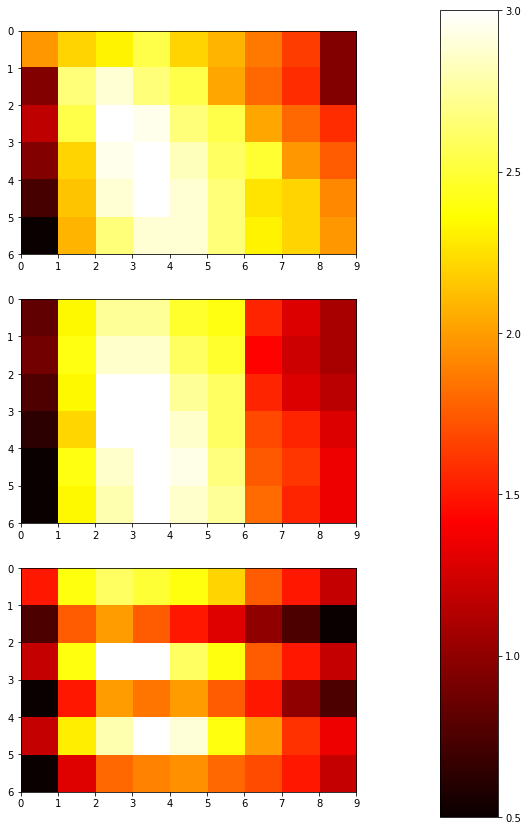

In [6]:
# dissimilar items hidden layer (delta = 0.6)
activation_patterns4a = [[1.4, 1.6, 1.7, 1.9, 1.6, 1.5,  1.3,  1.1, 0.5],
                         [0.5, 2,   2.2, 2,   1.9, 1.45, 1.25, 1.05, 0.5],
                         [0.7, 1.9, 2.3, 2.25, 2, 1.9, 1.45, 1.25, 1.05],
                         [0.5, 1.6, 2.25, 2.3, 2.15, 1.95, 1.85, 1.4, 1.2],
                         [0.3, 1.55, 2.2, 2.3, 2.2, 2, 1.65, 1.6, 1.35],
                         [0.1, 1.5, 2, 2.2, 2.2, 2, 1.7, 1.6, 1.4]]

# similar items hidden layer (delta = 0.4)
activation_patterns4b = [[1.35, 2.5, 2.8, 2.8, 2.6, 2.55, 1.9, 1.7, 1.55],
                         [1.4, 2.55, 2.9, 2.9, 2.7, 2.6, 1.8, 1.65, 1.55],
                         [1.3, 2.5, 3, 3, 2.8, 2.7, 1.9, 1.7, 1.6],
                         [1.2, 2.4, 3, 3, 2.9, 2.7, 2, 1.9, 1.7],
                         [1.1, 2.55, 2.9, 3, 2.95, 2.75, 2.05, 1.95, 1.75],
                         [1.1, 2.5, 2.85, 3, 2.9, 2.8, 2.1, 1.9, 1.75]]

# dissimilar and similar items hidden layer (delta = 0.65)
activation_patterns4c = [[1.5, 2.4, 2.6, 2.5, 2.4, 2.2, 1.75, 1.5, 1.2],
                         [0.75, 1.75, 2, 1.75, 1.5, 1.3, 1, 0.75, 0.5],
                         [1.2, 2.4, 3, 3, 2.6, 2.4, 1.75, 1.5, 1.2],
                         [0.5, 1.5, 2, 1.85, 2, 1.75, 1.5, 1, 0.75],
                         [1.2, 2.3, 2.8, 3, 2.9, 2.4, 2, 1.6, 1.35],
                         [0.5, 1.3, 1.8, 1.9, 1.95, 1.8, 1.7, 1.5, 1.2]]

# plotting
plt.subplots(3,1,figsize=(8,14))

# plotting dissimilar
plt.subplot(311)
plt.imshow(activation_patterns4a, extent=(x_min, x_max, y_max, y_min), interpolation='nearest', cmap=cm.hot)

# plotting similar
plt.subplot(312)
plt.imshow(activation_patterns4b, extent=(x_min, x_max, y_max, y_min), interpolation='nearest', cmap=cm.hot)

# plotting half and half
plt.subplot(313)
plt.imshow(activation_patterns4c, extent=(x_min, x_max, y_max, y_min), interpolation='nearest', cmap=cm.hot)

# axes
cax = plt.axes([0.95, 0.1, 0.1, 0.8])
plt.colorbar(cax=cax)
plt.show()

Alright cool, so we have our hidden layers for the three situations we want to model. Now, we want to train our model. So, we will initialize our weights at all 0 as per the paper, and train the weight vector here by mimicking a neural network's linear combination with the update rule of the paper. We first do it for the dissimilar items situation, after which we will do for the two other cases.

But, before we do that, we must define our labels to train our loss. We do so here with a dictionary and an arbitrary mapping. This will work as long as our mapping is consistent in our probabilities summing (I think?)

In [7]:
# compute permutations of a string
def permute_string(s):
    if len(s) == 0:
        return ['']
    prev_list = permute_string(s[1:len(s)])
    next_list = []
    for i in range(0,len(prev_list)):
        for j in range(0,len(s)):
            new_str = prev_list[i][0:j]+s[0]+prev_list[i][j:len(s)-1]
            if new_str not in next_list:
                next_list.append(new_str)
    return next_list

# compute for our sequence of items
permutations = permute_string('123456')
print(permutations)

['123456', '213456', '231456', '234156', '234516', '234561', '132456', '312456', '321456', '324156', '324516', '324561', '134256', '314256', '341256', '342156', '342516', '342561', '134526', '314526', '341526', '345126', '345216', '345261', '134562', '314562', '341562', '345162', '345612', '345621', '124356', '214356', '241356', '243156', '243516', '243561', '142356', '412356', '421356', '423156', '423516', '423561', '143256', '413256', '431256', '432156', '432516', '432561', '143526', '413526', '431526', '435126', '435216', '435261', '143562', '413562', '431562', '435162', '435612', '435621', '124536', '214536', '241536', '245136', '245316', '245361', '142536', '412536', '421536', '425136', '425316', '425361', '145236', '415236', '451236', '452136', '452316', '452361', '145326', '415326', '451326', '453126', '453216', '453261', '145362', '415362', '451362', '453162', '453612', '453621', '124563', '214563', '241563', '245163', '245613', '245631', '142563', '412563', '421563', '425163',

In [8]:
labels_mapping = dict() # were we store our labels
i = 0 # index counter for mapping

# dimensions of onehot vector
onehot = np.zeros((720,1)) # 720 by 1

# iterate over our permutations and store the mapping
for permutation in permutations:
  onehot[i] = 1 # set target index
  i += 1 # increment for next
  labels_mapping[permutation] = onehot # store
  onehot = np.zeros((720,1)) # reset to no mapping for next

# verify success
print(labels_mapping['123456']) # looks right!

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

Good, now we can train.

In [9]:
# weights between internal and output units
ws = np.zeros((n_internal, n_output))

# train the weights - dissimilar items situation
# reduce to 100 epochs to train faster
for timestep in range(10): # train for 2500 epochs
  # track progress
  print("Epoch #" + str(timestep))
  
  # for each epoch, we pass all of our 720 possible items
  for permutation in labels_mapping:
    
    # our target value for this specific permutation
    t_i = labels_mapping[permutation] # this is a 720x1 onehot array
  
    # theses will reset every timestep, which is what we want
    a = np.zeros(n_output) # net input to units
    o = np.zeros(n_output) # activations of the output units

    for output_node_i in range(720): # train weights connection for each output node separatetly
      # loop over our 54 hidden layer nodes
      for i in range(n_item):
        for j in range(rank):
          # simply the linear combination of weights * input for this specific 
          # output node. This is our current predicted value for this output node
          # at this specific timestep
          a[output_node_i] += activation_patterns4a[i][j] * ws[i*j][output_node_i]

    # now that we have our a_i, we can calculate our o_i
    o = np.exp(a) / sum(np.exp(a)) # this is just applying the softmax function

    # now that we have our o's, we can update our weights
    # in the paper, a parameter is h_j, this parameter is simply the activation
    # pattern at i,j in our activation patterns heatmap

    # update our weight vector each weight separately
    for i in range(n_item):
      for j in range(rank):
        h_j = activation_patterns4a[i][j] # indexing for our h_j
        # loop over our 54 hidden layer nodes
        for k in range(720):
          # t_i is our target value, which is 1 if we have the right prediction
          # and 0 otherwise
          t_ik = t_i[k] # value of target for this specific guess

          # update the weights!
          ws[i*j][k] += alpha * (t_ik - o[k]) * h_j

# training done!?

Epoch #0
Epoch #1


In order to get the porportion of predicted times a number is found in its right position, we can just print the o vector and sum over our probabilities, which makes it a simple way to get the information to plot the working memory behavior without having to formerly run the model with actual inputs and outputs, since the law of large numbers will lead to a convergence to these probabilities anyways. Now that I think of it, I'm fairly sure this is probably how the researchers did it themselves. 

In [10]:
# the final o vector we have stored is our updated predictions after 2500
# timesteps, so we can just print it here to see how it looks
print(o)

[0.00120487 0.0012053  0.00120573 0.00120617 0.0012066  0.00120703
 0.00120746 0.00120789 0.00120833 0.00120876 0.00120919 0.00120962
 0.00121006 0.00121049 0.00121093 0.00121136 0.00121179 0.00121223
 0.00121266 0.0012131  0.00121354 0.00121397 0.00121441 0.00121484
 0.00121528 0.00121572 0.00121615 0.00121659 0.00121703 0.00121747
 0.00121791 0.00121834 0.00121878 0.00121922 0.00121966 0.0012201
 0.00122054 0.00122098 0.00122142 0.00122186 0.0012223  0.00122274
 0.00122318 0.00122363 0.00122407 0.00122451 0.00122495 0.00122539
 0.00122584 0.00122628 0.00122672 0.00122717 0.00122761 0.00122806
 0.0012285  0.00122895 0.00122939 0.00122984 0.00123028 0.00123073
 0.00123117 0.00123162 0.00123207 0.00123252 0.00123296 0.00123341
 0.00123386 0.00123431 0.00123475 0.0012352  0.00123565 0.0012361
 0.00123655 0.001237   0.00123745 0.0012379  0.00123835 0.0012388
 0.00123926 0.00123971 0.00124016 0.00124061 0.00124106 0.00124152
 0.00124197 0.00124242 0.00124288 0.00124333 0.00124379 0.0012442

In order to figure out which probabilities to sum with which, we need to map which index i,j is mapped with which item in which position. We built an arbitrary mapping earlier and used it for our training, so this is the mapping we will use here. We want to sum all indices where 1 is in position 1, all indices where 2 is in position 2, etc.

In [23]:
positions = np.array([0.0,0.0,0.0,0.0,0.0,0.0]) # where we will store

i = 0 # counter to index in o vector
for key, value in labels_mapping.items():
  # check sequentially if each is in its right position  
  if key[0] == '1':
    positions[0] += o[i]
  if key[1] == '2':
    positions[1] += o[i]
  if key[2] == '3':
    positions[2] += o[i]
  if key[3] == '4':
    positions[3] += o[i]
  if key[4] == '5':
    positions[4] += o[i]
  if key[5] == '6':
    positions[5] += o[i]
  # increment to the next probability
  i += 1
  
# render to see how it looks
print(positions)

[0.16659829 0.16629688 0.16618862 0.16815354 0.17095666 0.15004266]


In [0]:




# also need to generalize the variable names and run it for the other activation patterns






Alright, our model works! All we need to do now is plot the graphs of the appropriate summed probabilities.

## Task 1.2 Reproduce positional accuracy (fig 5d)

## Task 1.3 Reproduce transposition gradient effects (fig 5e)